# Task 6 : 选择特征，训练模型，评估模型性能

In [1]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from IoTTotalFeature import CIoTTotalFeature
from IoTSample import CIoTSample
from SHSample import CSHSample
from IoTPrompt import CIoTPrompt
from IoTModel import CIoTModel,get_test_infograph_features
from SHDataProcess import CSHDataProcess
from SHFeatureSelect import CSHFeature
from Config import g_data_root,get_attack_score,g_resolved_columns
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHModelRegression import CSHModelRegression
from SHModelClassify import CSHModelClassify
from SHEvaluation import CSHROC
from IoTNoise import CIoTNoise
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h2o
from Config import g_data_root
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_feature_root = "%s/features"%g_data_root
g_result_root = "%sresult"%g_data_root

In [2]:
h2o.connect(verbose=False)

<H2OConnection to http://localhost:54321, no session>

# 调试

In [3]:
class CClassifyEvaluate:

    def __init__(self,attack):
        self.m_model = CSHModelClassify()
        self.m_col_x = None
        self.m_col_y = None
        
    #根据样本中Label的比例，对score/sum进行二值化
    def get_level(self,attack,df_data,measure):
        ioTPrompt = CIoTPrompt(attack)
        df_label = ioTPrompt.load_packet_label()
        df_label = df_label[df_label['noised']==False].reset_index(drop=True)
        value_ratio = (df_label['Label'].value_counts() ) / len(df_label['Label'])
        df_sample = df_data.copy(deep=True)
        df_sample['score'] = df_sample[measure]
        bins,intervals = CIoTCommon.get_level_by_score(df_sample,value_ratio)
        return bins.astype(int)
        
    def load_sample(self,col_y):
        ioTPrompt = CIoTPrompt(attack)
        if col_y == 'Label':
            df_total = ioTPrompt.load_packet_label()
            df_total = df_total[df_total['noised']==False].reset_index(drop=True)
        else:
            df_total = ioTPrompt.load_packet_score()
            df_total = df_total[df_total['noised']==False].reset_index(drop=True)
            df_total['score'] = (df_total['score'] - df_total['score'].mean()) / df_total['score'].std()
            df_total['sum'] = (df_total['sum'] - df_total['sum'].mean()) / df_total['sum'].std()
            df_total['Level'] = self.get_level(attack,df_total,'score')
            df_total['Level_Sum'] = self.get_level(attack,df_total,'sum')
        
        df_total = CIoTModel(attack).select_packet_features(df_total)
        df_base = df_total.drop(['id','time','protocol','noised','group','score','sum'], axis=1,errors='ignore')
        ds_label = df_base[col_y]
        df_base = df_base.drop(['Level_Sum','Level','Label'], axis=1,errors='ignore')
        df_base[col_y] = ds_label
        self.m_col_y = col_y
        self.m_col_x = df_base.keys().tolist()
        for col in self.m_col_x:
            if col.find("FLAT") < 0 and col != col_y and col_y != 'Label':
                print("Sample includes error column ",col) 
        self.m_col_x.remove(col_y)
        df_sample,scale_colums = CSHDataProcess.get_scale(df_base,x_columns=self.m_col_x,y_column=self.m_col_y)
        df_train,df_test = CSHSample.split_dataset(df_sample)
        return df_train,df_test
  
    def train(self,df_train):
        self.m_model.train(df_train,x_columns=self.m_col_x,y_column=self.m_col_y,train_ratio = 0)
    
    def add_noise(self,df_test,noised_columns = [],ratio=0.1):
        df_data = df_test.copy(deep = True)
        dtypes_dict = df_test.dtypes.to_dict()
        for feature in df_data.keys().tolist():
            if feature in [self.m_col_y]:
                continue
            if not (feature in noised_columns):
                continue
            type1 = dtypes_dict[feature]
            df_data[feature] = CIoTNoise.add_noise(feature,type1,df_data,ratio)
        return df_data
        
    def test(self,df_test,noised_columns=[],ratio=0.1):
        if noised_columns == []:
            noised_columns = self.m_col_x
        if ratio == 0:
            df_noised = df_test
        else:
            df_noised = self.add_noise(df_test,noised_columns,ratio=ratio)
        df_result = self.m_model.evaluate(df_noised,x_columns=self.m_col_x,y_column=self.m_col_y)
        df_result['ratio'] = ratio
        return df_result

In [4]:
class CRegressionEvaluate:

    def __init__(self,attack):
        self.m_model = CSHModelRegression()
        self.m_col_x = None
        self.m_col_y = None
        
    def load_sample(self,col_y):
        ioTPrompt = CIoTPrompt(attack)
        df_total = ioTPrompt.load_packet_score()
        df_total = CIoTModel(attack).select_packet_features(df_total)
        df_total['score'] = (df_total['score'] - df_total['score'].mean()) / df_total['score'].std()
        df_total = df_total[df_total['noised']==False].reset_index(drop=True)
        df_base = df_total.drop(['id','time','protocol','Level','Level_Sum','noised','group','Label'], axis=1,errors='ignore')

        if col_y == 'score':
            del df_base['sum']
        else:
            del df_base['score']
            
        self.m_col_y = col_y
        self.m_col_x = df_base.keys().tolist()
        for col in self.m_col_x:
            if col.find("FLAT") < 0 and col != col_y:
                print("Sample includes error column ",col) 
        self.m_col_x.remove(col_y)
        df_sample,scale_colums = CSHDataProcess.get_scale(df_base,x_columns=self.m_col_x,y_column=self.m_col_y)
        df_train,df_test = CSHSample.split_dataset(df_sample)
        return df_train,df_test
  
    def train(self,df_train):
        self.m_model.train(df_train,x_columns=self.m_col_x,y_column=self.m_col_y,train_ratio = 0)
    
    def add_noise(self,df_test,noised_columns = [],ratio=0.1):
        df_data = df_test.copy(deep = True)
        dtypes_dict = df_test.dtypes.to_dict()
        for feature in df_data.keys().tolist():
            if feature in [self.m_col_y]:
                continue
            if not (feature in noised_columns):
                continue
            type1 = dtypes_dict[feature]
            df_data[feature] = CIoTNoise.add_noise(feature,type1,df_data,ratio)
        return df_data
        
    def test(self,df_test,noised_columns=[],ratio=0.1):
        if noised_columns == []:
            noised_columns = self.m_col_x
        if ratio == 0:
            df_noised = df_test
        else:
            df_noised = self.add_noise(df_test,noised_columns,ratio=ratio)
        df_result = self.m_model.evaluate(df_noised,x_columns=self.m_col_x,y_column=self.m_col_y)
        df_result['ratio'] = ratio
        return df_result

In [5]:
def train_test(attack,measure ):
    if measure in ['sum','score']:
        evaluter = CRegressionEvaluate(attack)
    else:
        evaluter = CClassifyEvaluate(attack)
        
    df_train,df_test = evaluter.load_sample(measure)
    evaluter.train(df_train)
    df_result = pd.DataFrame()
    
    noised_columns = []
    for col in evaluter.m_col_x:
        if col == measure:
            continue
        if measure == 'Label':
            noised_columns.append(col)
        elif measure in ['Level','Level_Sum']:
            if col.find("FLAT") > 0 and len(noised_columns) <= 46 : #基线session中，有56个特征添加噪音，这里也给46个特征添加噪音
                noised_columns.append(col)                
        elif measure in ['sum','score']:
            noised_columns.append(col)
        else:
            print("Unknown measure",measure)

    for ratio in tqdm([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
        df_tmp = evaluter.test(df_test,noised_columns=noised_columns,ratio=ratio)
        df_result = pd.concat([df_result,df_tmp], ignore_index=True)
    df_result['kind'] = measure
    return df_result.reset_index(drop=True)
    
def show_result(df_result,isClassify):
    for model in df_result['model'].unique():
        #if model != 'ann':
        #    continue
        df_tmp = df_result[df_result['model']==model]
        df_tmp = df_tmp.drop(['model','kind'], axis=1,errors='ignore')
        df_tmp = df_tmp.groupby('ratio').mean()
        df_tmp = df_tmp.sort_values(by='ratio').reset_index()
        if isClassify:
            df_long = pd.melt(df_tmp,id_vars=['ratio'], value_vars=['recall', 'precision','accuracy','f1_score'], var_name='metric', value_name='value')
        else:
            df_long = pd.melt(df_tmp,id_vars=['ratio'], value_vars=['mse', 'rmse','mae','r2'], var_name='metric', value_name='value')
        sns.barplot(x='ratio', y='value',hue='metric',orient='v',ci=None,data=df_long)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
        plt.xlabel('Noise ratio', fontsize=10)
        plt.ylabel('Metric value', fontsize=10)
        plt.title('Performance of %s'%model, fontsize=12)
        plt.show()

In [6]:
attack = "Backdoor_attack"
df_class_label = train_test(attack,'Label')
df_class_sum = train_test(attack,'Level')
df_class_score = train_test(attack,'Level_Sum')
df_regression_sum = train_test(attack,'sum')
df_regression_score = train_test(attack,'score')
df_class_result = pd.concat([df_class_label,df_class_sum,df_class_score],ignore_index=True).reset_index(drop=True)
df_regression_result = pd.concat([df_regression_sum,df_regression_score],ignore_index=True).reset_index(drop=True)
df_class_result['attack'] = attack
df_regression_result['attack'] = attack
df_class_result.to_csv("./IIoTSet/result/ML-performance/task-6-classify.csv")
df_regression_result.to_csv("./IIoTSet/result/ML-performance/task-6-regression.csv")

select feature: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4019.31it/s]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

select feature: 100%|█████████████████████████████████████████████████████████████████████████████████| 707/707 [00:01<00:00, 550.25it/s]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

select feature: 100%|█████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 889.89it/s]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
naivebayes prediction progress: |████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |█████████████████████████

select feature: 100%|█████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 814.59it/s]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

select feature: 100%|█████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 891.42it/s]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


  0%|          | 0/11 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

OSError: Cannot save file into a non-existent directory: '/IIoTSet/result/ML-performance'

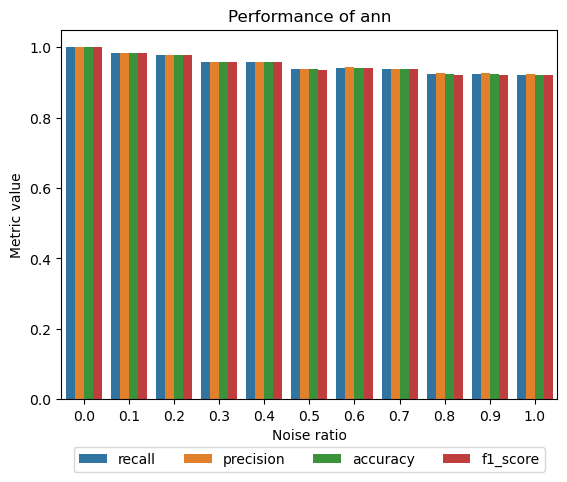

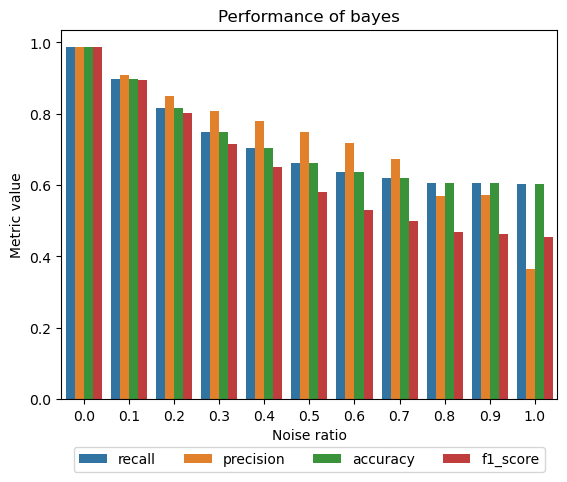

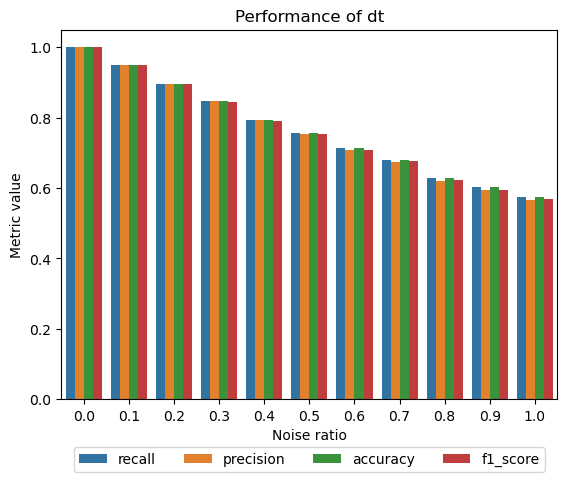

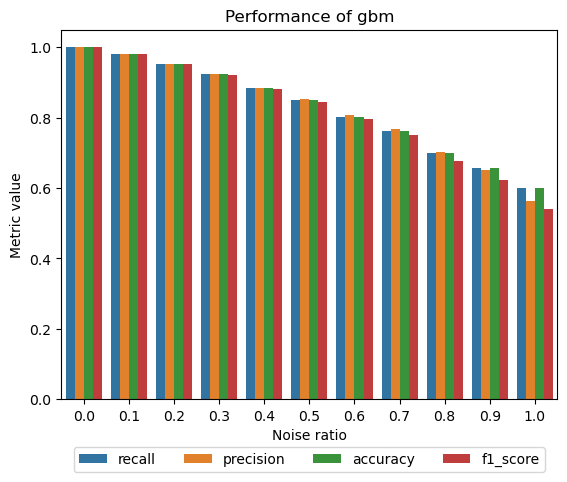

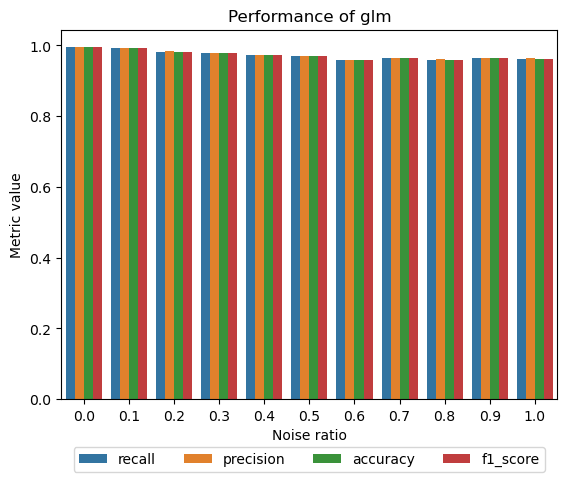

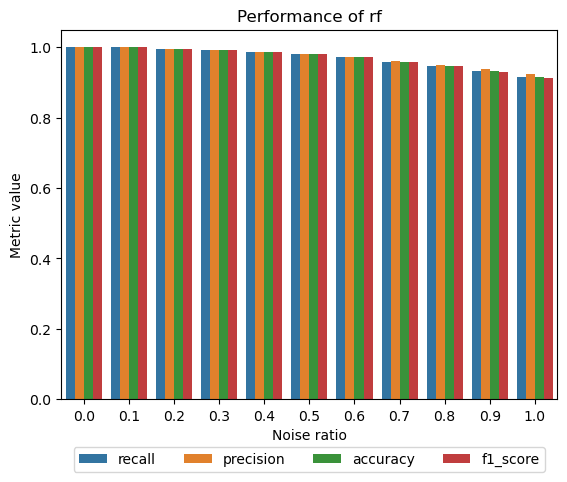

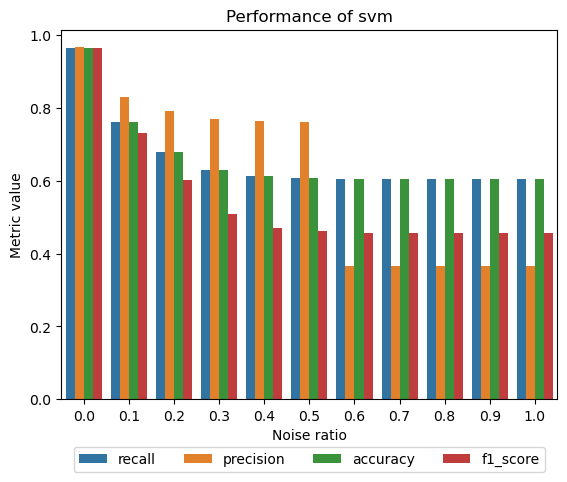

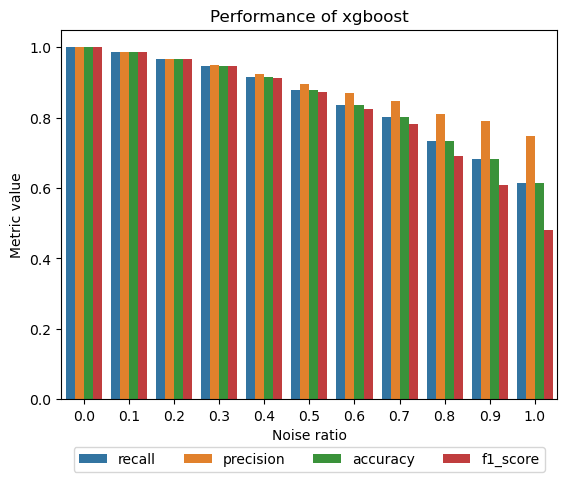

In [8]:
#这个只是参考，使用Session的图做对比
show_result(df_class_label,True)

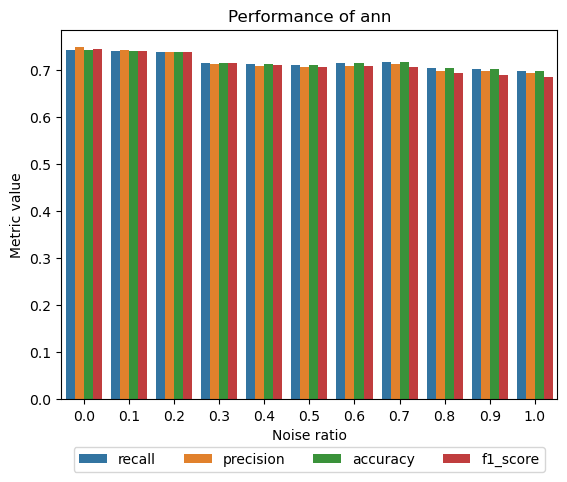

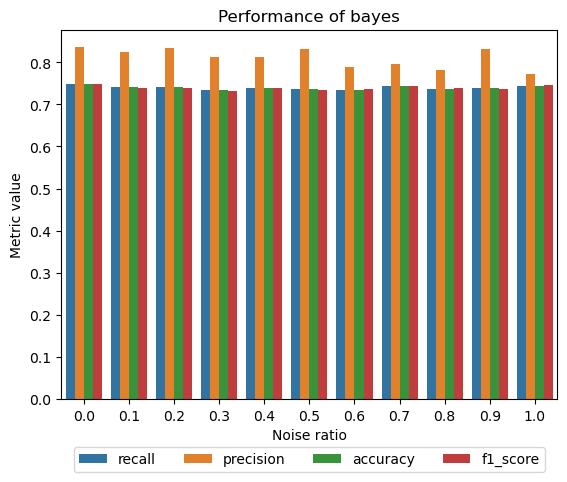

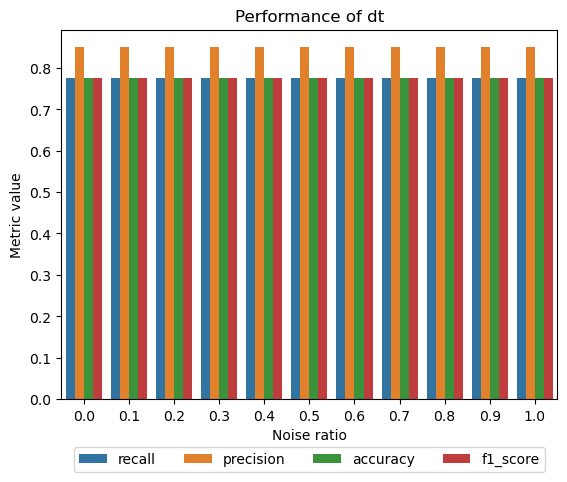

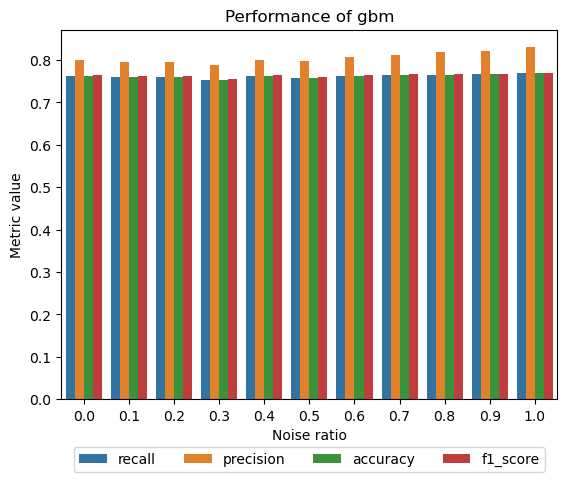

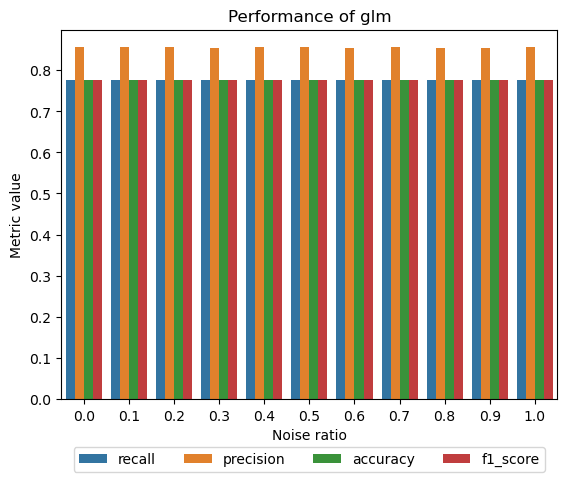

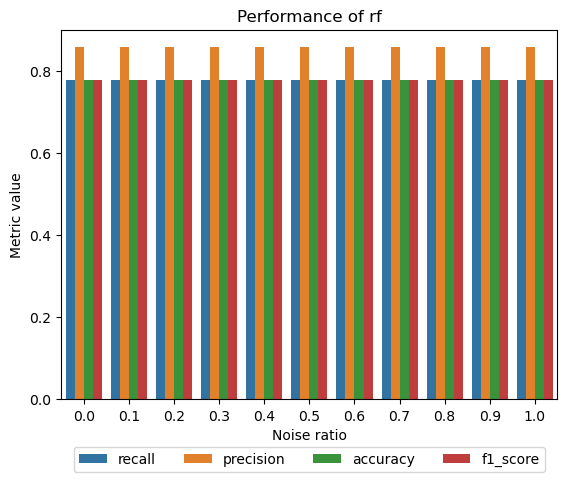

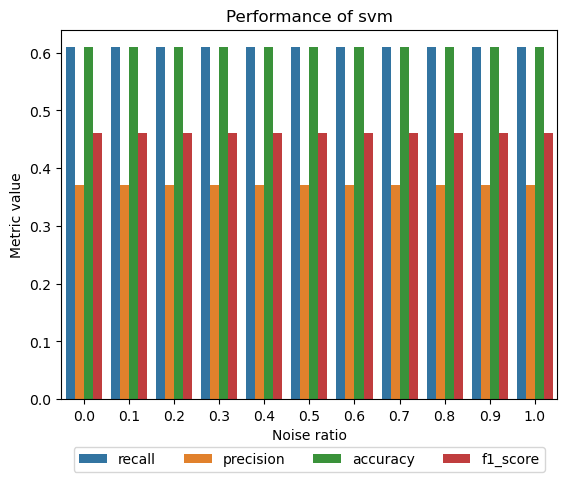

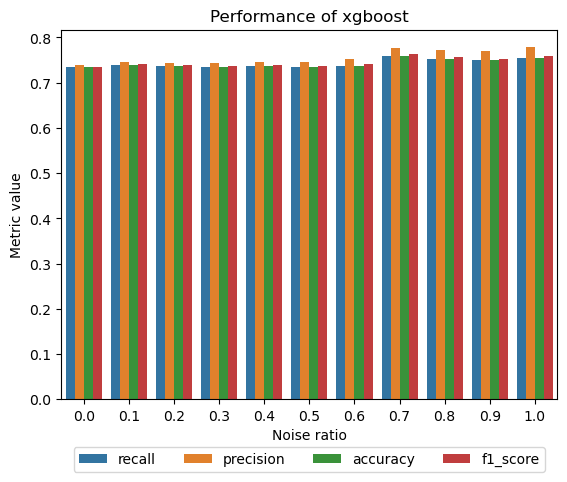

In [9]:
show_result(df_class_sum,True)

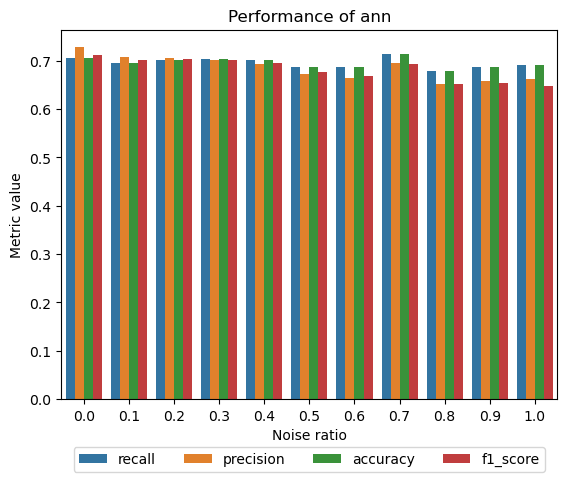

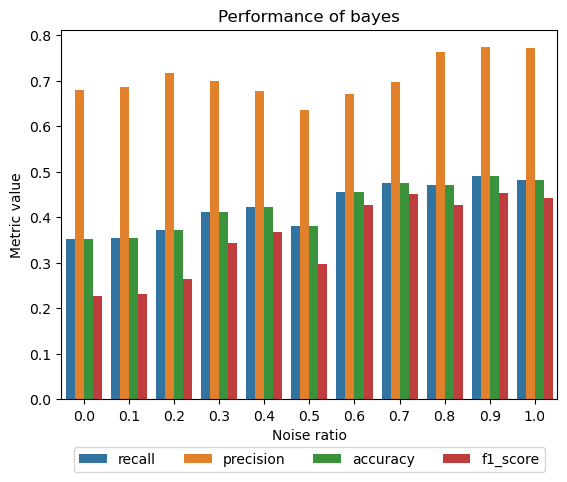

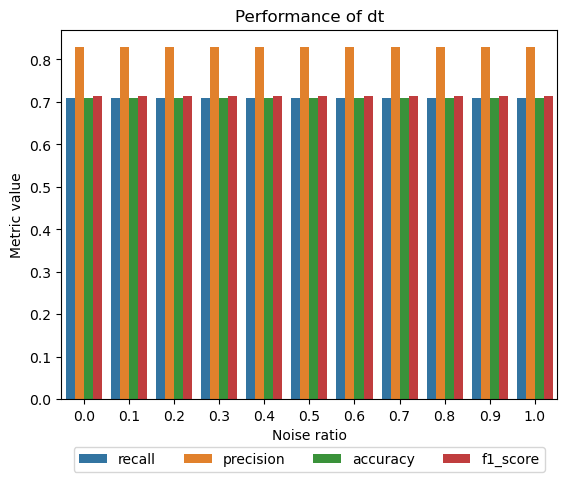

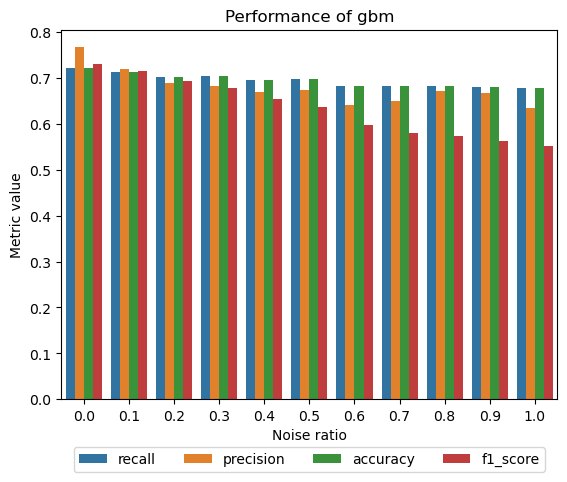

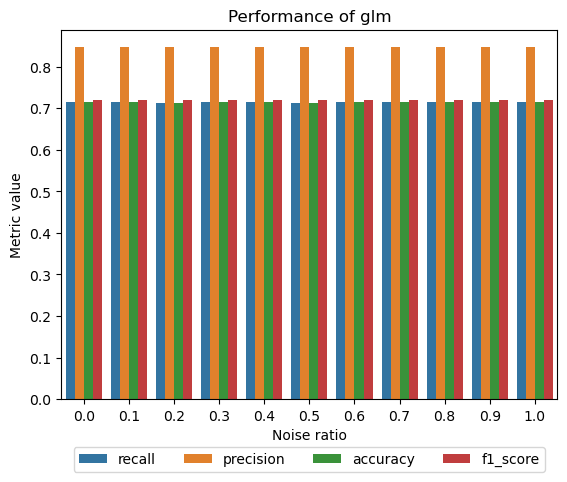

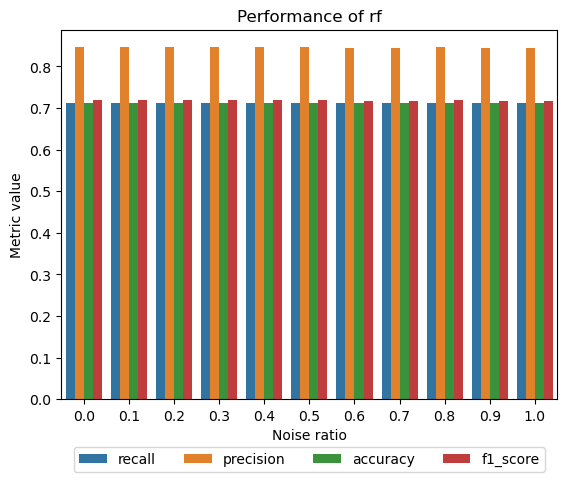

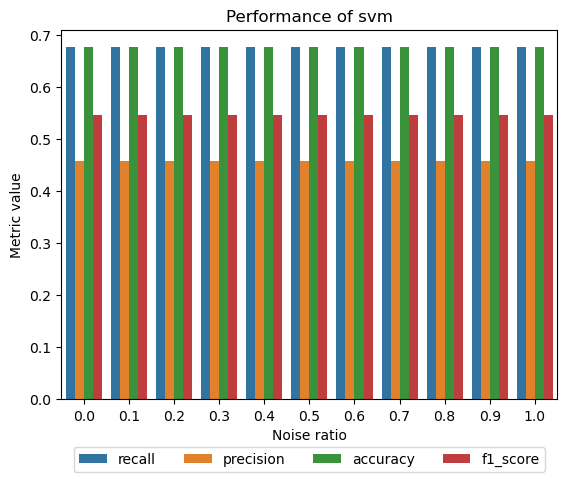

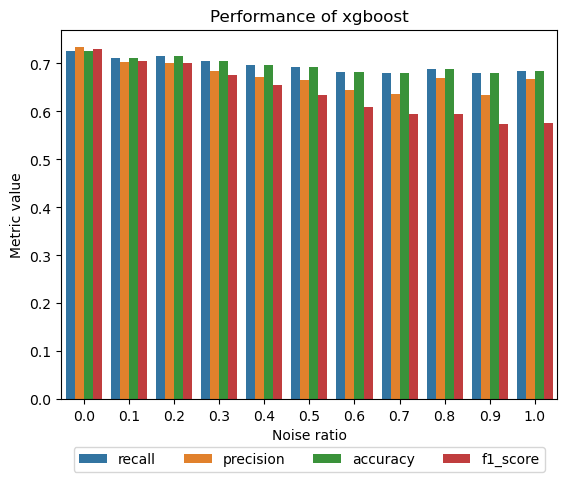

In [10]:
show_result(df_class_score,True)

In [11]:
df_tmp = df_class_result.copy(deep=True)
del df_tmp['confusion_matrix']
df_tmp = df_tmp[df_tmp['model']=='ann']
df_tmp.groupby(['model','ratio','kind']).mean()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
df_result = pd.concat([df_regression_sum,df_regression_score],ignore_index=True).reset_index(drop=True)
df_temp = df_result.groupby(['model','kind','ratio']).mean().reset_index(drop=False)
sns.lineplot(x='ratio',y='rmse',hue='kind',ci=None,data = df_temp)
plt.show()
for model in df_temp['model'].unique():
    df_tmp = df_temp[df_temp['model']==model]
    sns.lineplot(x='ratio',y='rmse',hue='kind',ci=None,data = df_tmp)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
    plt.xlabel('Noise ratio', fontsize=10)
    plt.ylabel('Metric value', fontsize=10)
    plt.title('MSE of %s'%model, fontsize=12)
    plt.show()

# 汇总